In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/sample_submission.csv
/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/train.csv
/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/test.csv


In [19]:
train = pd.read_csv("/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/train.csv")
test = pd.read_csv("/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/test.csv")

In [20]:
train.head()


,timestamp,average_fare,rides_completed,driver_availability,surge_multiplier,vehicle_type,weather,traffic_index,special_event
0,2021-01-01 00:00:00,20.780423,457,49.170948,1.0,bike,Clear,63,0
1,2021-01-01 00:00:00,90.000000,80,30.000000,1.0,car,Clear,53,0
2,2021-01-01 00:00:00,41.197085,239,39.110219,1.0,auto,Clear,35,0
3,2021-01-01 01:00:00,20.772227,141,30.000000,1.5,bike,Stormy,83,0
4,2021-01-01 01:00:00,90.969805,98,30.000000,1.0,car,Clear,26,0


### Task 1: Data Exploration and Preparation (1 mark)

- Conduct exploratory data analysis to identify trends, patterns, and anomalies in fare data for each vehicle type (bikes, autos, and cars) in Quahog City.
- Using appropriate visualizations and techniques, provide an in-depth analysis on the nature of the average fare and other features in the dataset.

In [33]:
#importing other necessary librarires
import seaborn as sns  
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63015 entries, 0 to 63014
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            63015 non-null  datetime64[ns]
 1   average_fare         63015 non-null  float64       
 2   rides_completed      63015 non-null  int64         
 3   driver_availability  63015 non-null  float64       
 4   surge_multiplier     63015 non-null  float64       
 5   vehicle_type         63015 non-null  object        
 6   weather              63015 non-null  object        
 7   traffic_index        63015 non-null  int64         
 8   special_event        63015 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 4.3+ MB
None
                 timestamp  average_fare  rides_completed  \
count                63015  63015.000000     63015.000000   
mean   2022-03-14 14:00:00     70.186256       376.739760

**timestamp dtype is "object", so we're changing it to "timestamp"**

In [22]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63015 entries, 0 to 63014
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            63015 non-null  datetime64[ns]
 1   average_fare         63015 non-null  float64       
 2   rides_completed      63015 non-null  int64         
 3   driver_availability  63015 non-null  float64       
 4   surge_multiplier     63015 non-null  float64       
 5   vehicle_type         63015 non-null  object        
 6   weather              63015 non-null  object        
 7   traffic_index        63015 non-null  int64         
 8   special_event        63015 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 4.3+ MB
None


**Now we can see that the dtype of timestamp is changed.**

**Next we'll check for missing values and drop those.**

In [23]:
missing_values = train.isnull().sum()
print("Missing values in each column:\n", missing_values)

train.dropna(inplace=True)

Missing values in each column:
 timestamp              0
average_fare           0
rides_completed        0
driver_availability    0
surge_multiplier       0
vehicle_type           0
weather                0
traffic_index          0
special_event          0
dtype: int64


**Since the data is clean with no missing values, we will pprocees with exploratory data analysis by visualizing them.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

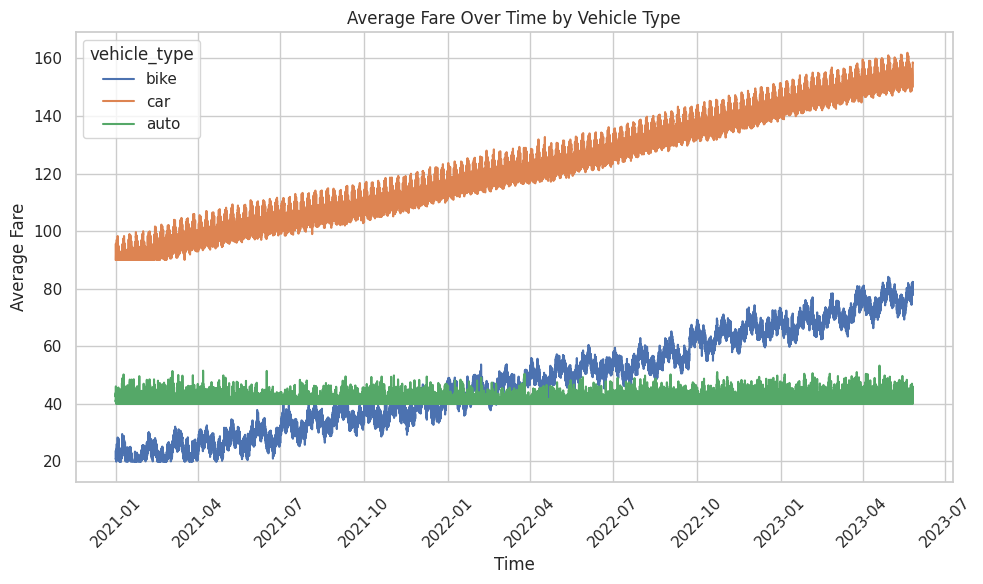

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=train, x='timestamp', y='average_fare', hue='vehicle_type')
plt.title("Average Fare Over Time by Vehicle Type")
plt.xlabel("Time")
plt.ylabel("Average Fare")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**We see that there is a trend for bike and car. Auto doesnt have a trend.
Bike appears to have seasonality.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


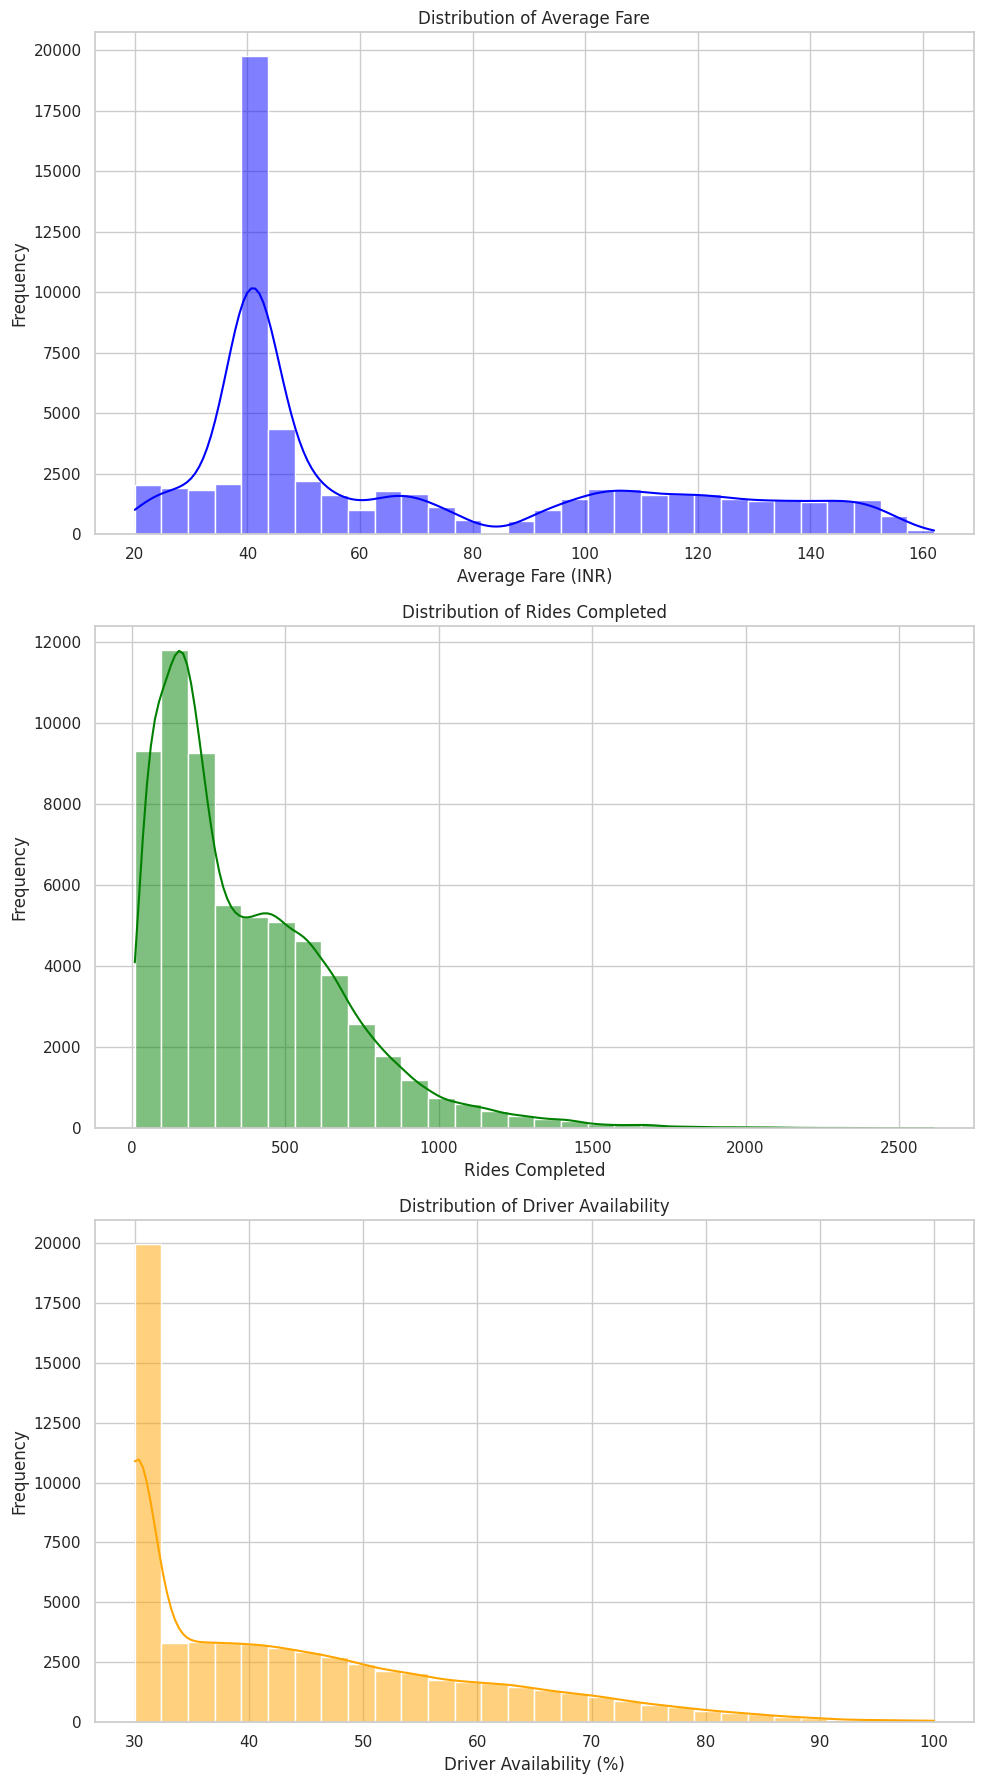

In [25]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Histogram and KDE for average fare
sns.histplot(data=train, x='average_fare', bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Average Fare")
axes[0].set_xlabel("Average Fare (INR)")
axes[0].set_ylabel("Frequency")

# Histogram and KDE for rides completed
sns.histplot(data=train, x='rides_completed', bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title("Distribution of Rides Completed")
axes[1].set_xlabel("Rides Completed")
axes[1].set_ylabel("Frequency")

# Histogram and KDE for driver availability
sns.histplot(data=train, x='driver_availability', bins=30, kde=True, ax=axes[2], color='orange')
axes[2].set_title("Distribution of Driver Availability")
axes[2].set_xlabel("Driver Availability (%)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


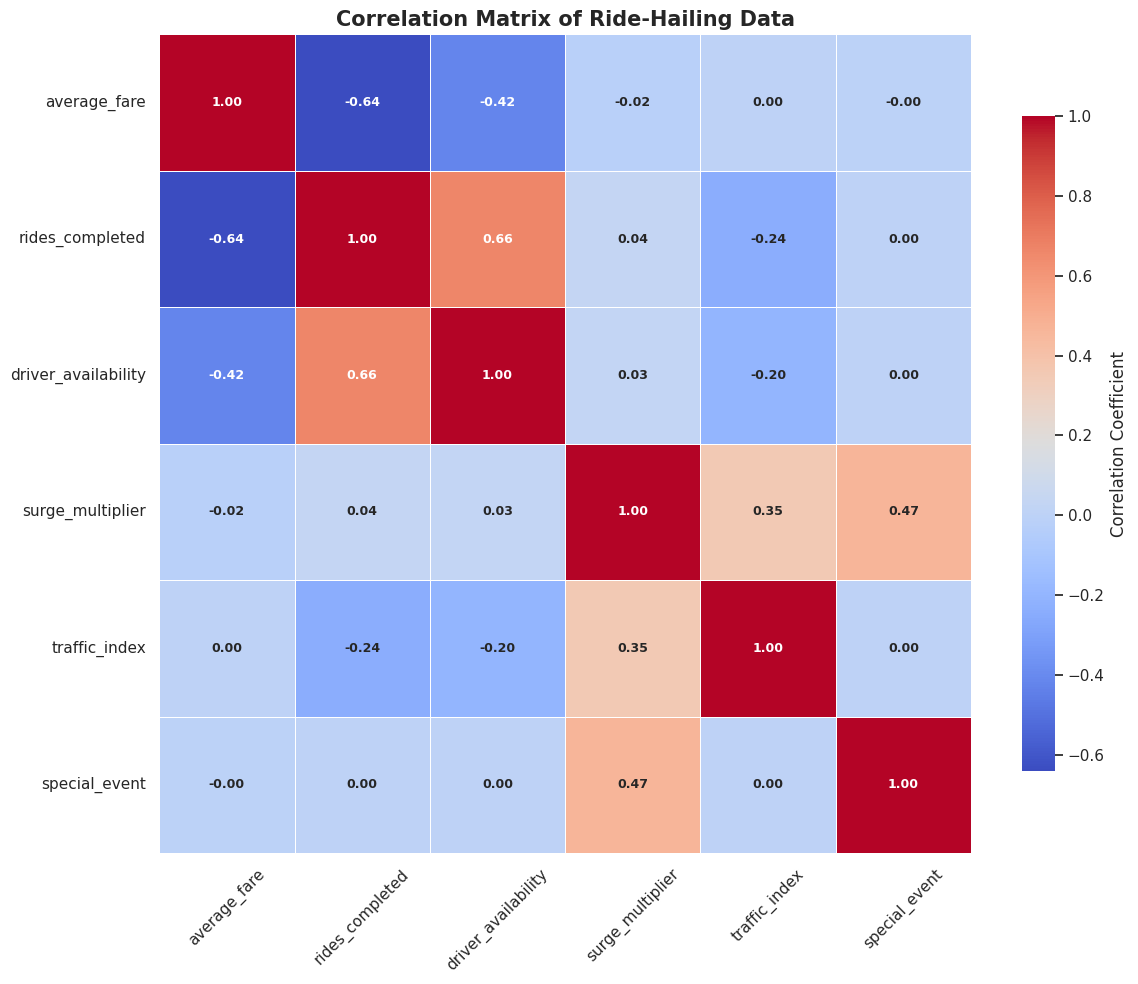

In [26]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    train.corr(numeric_only=True),
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 9, "weight": "bold"},
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"}
)
plt.title("Correlation Matrix of Ride-Hailing Data", fontsize=15, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Here we see that average_fare, rides_completed and driver_availability are correalated to each other.
average_fare and driver_availability are negatively correalated, from this we can infer that, when more drivers are available, the fares reduce, which makes sense.**

**We also see that surge_multiplier is positively correlated to special_event. From this we can infer that, when theres a special_event, the surge pricing multiplier increase. This also makes sense as the surge multiplier during special_events like 
concerts, sports events, etc.)
Inclement weather (rain or snow)
Rush hours (morning and evening commutes)
Local emergencies or incidents (traffic accidents, road closures)**

### Task 2: Time Series Characterization (1 mark)

- Building on your exploratory analysis, examine the time series characteristics of the average fare for each vehicle type in Quahog City.
- Implement the Holt and Holt-Winters methods to model and forecast the average fare for each vehicle type.
- Interpret the results and discuss the implications for RideWave's business.

**We first start the analysis by decomposing the average_fare timeseries of each vehicle type to its components: Trend, Seasonality and Residuals.**

**We chose "additive" decomposition as the seasonality in the bike doesnt seem to increase with time.**

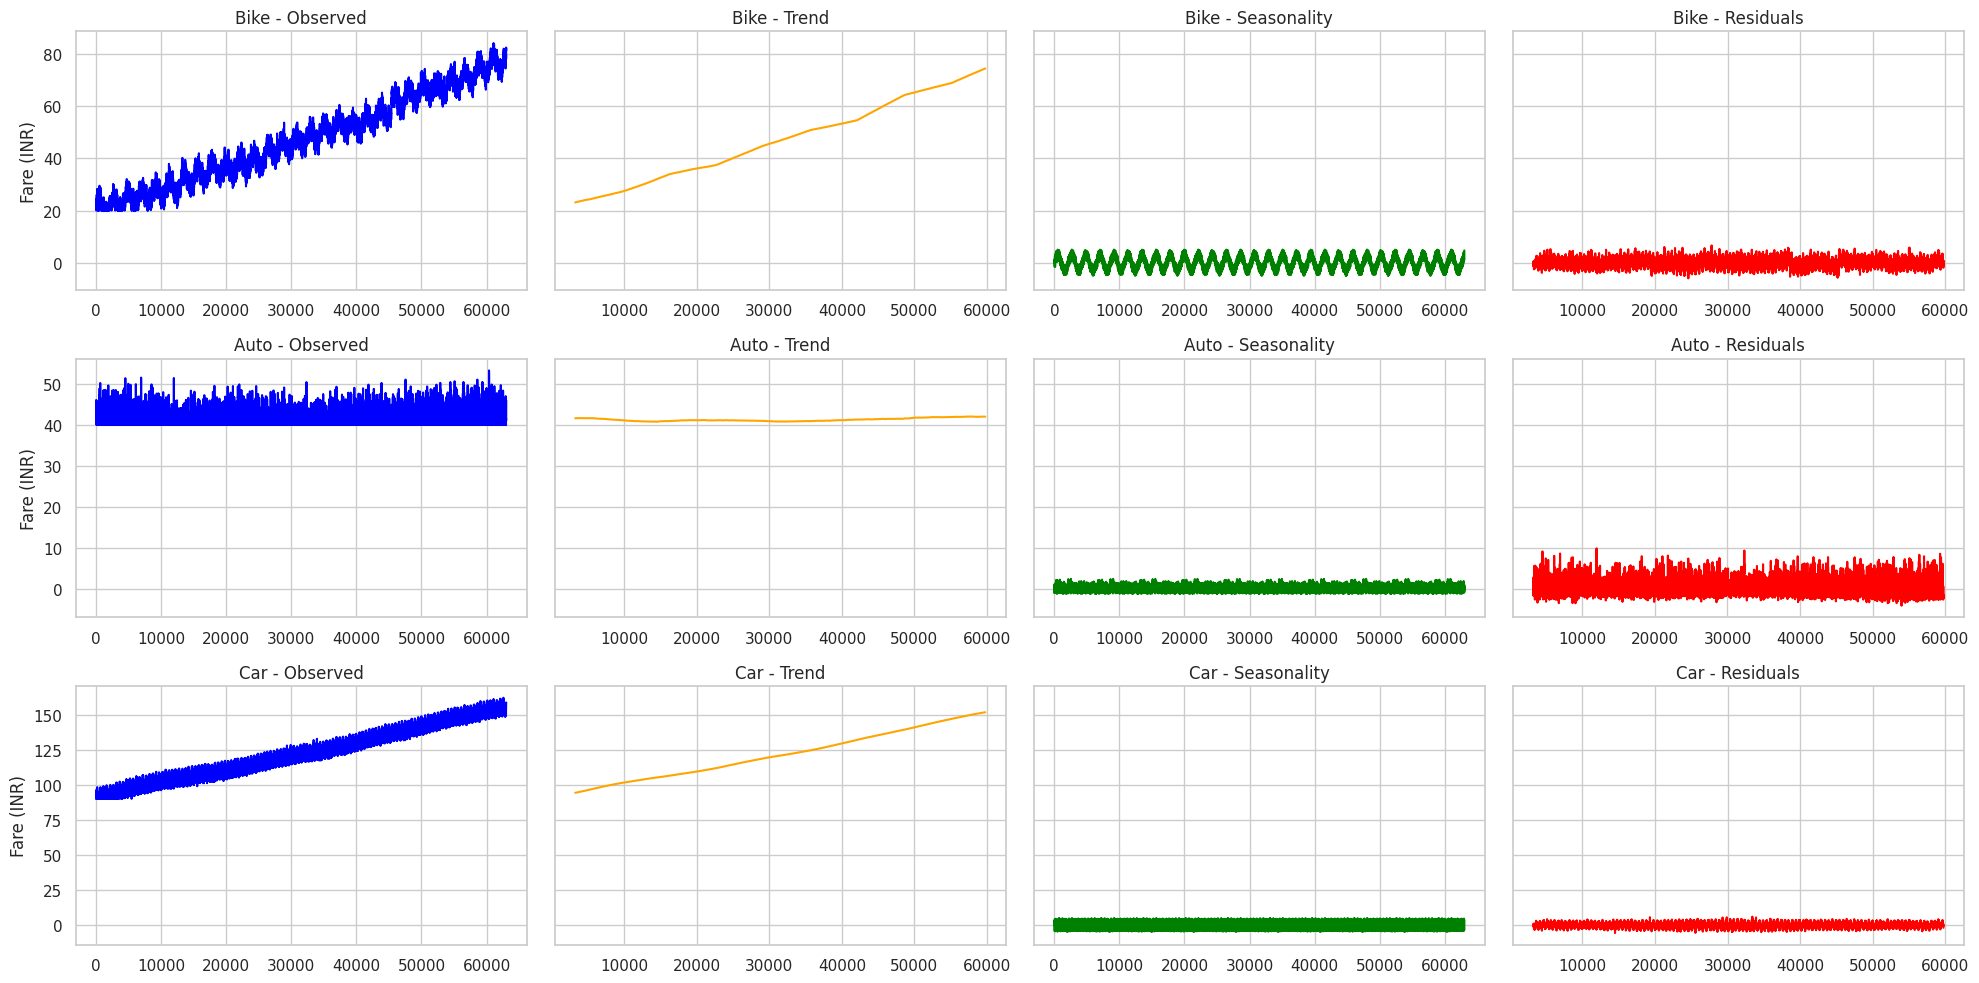

In [27]:
vehicle_types = ['bike', 'auto', 'car']

fig, axes = plt.subplots(len(vehicle_types), 4, figsize=(20, 10), sharey='row')

# Loop through each vehicle type
for i, vehicle in enumerate(vehicle_types):
    # Filter data for the current vehicle type
    data = train[train['vehicle_type'] == vehicle]['average_fare']
    
    # Decompose the time series
    decomposition = seasonal_decompose(data, model='additive', period=2160) 
    
    # Plotting observed, trend, seasonality, and residuals
    decomposition.observed.plot(ax=axes[i, 0], title=f'{vehicle.capitalize()} - Observed', color='blue')
    axes[i, 0].set_ylabel('Fare (INR)')
    
    decomposition.trend.plot(ax=axes[i, 1], title=f'{vehicle.capitalize()} - Trend', color='orange')
    
    decomposition.seasonal.plot(ax=axes[i, 2], title=f'{vehicle.capitalize()} - Seasonality', color='green')
    
    decomposition.resid.plot(ax=axes[i, 3], title=f'{vehicle.capitalize()} - Residuals', color='red')
    
    axes[i, 3].set_ylabel('Residuals')
    
plt.tight_layout()
plt.show()


**We used the period=2160, which is one quarter of the year. (We tried and experimented with day, week, month and quater ; and we found out that quater decomposes it the best).**

**From the graphs above, we can infer that:
Bike: Bike has a high trend and a seasonality which repeats every month.
Auto: Auto has no trend or seasonality.
Car: Car has a trend and day seasonality.**


Stationarity Test for Auto:
ADF Statistic: -20.739513354918834
p-value: 0.0
Critical Values:
   1%: -3.4306618194195084
   5%: -2.8616778135768097
   10%: -2.5668433543400266
auto series is stationary

Forecasting for Auto using Holt and Holt-Winters models


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_30/2551056400.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=pivoted_fares.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')


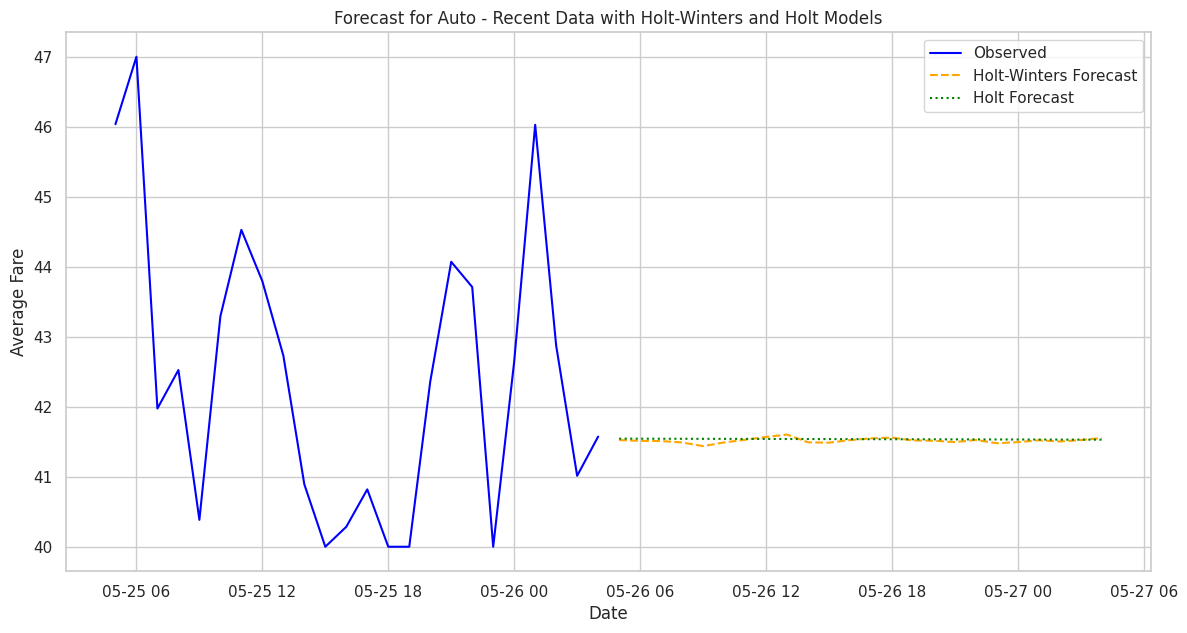


Stationarity Test for Bike:
ADF Statistic: -1.5575504421726767
p-value: 0.5048745215832674
Critical Values:
   1%: -3.4306620575014812
   5%: -2.8616779187954124
   10%: -2.5668434103459283
bike series is not-stationary

Forecasting for Bike using Holt and Holt-Winters models


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_30/2551056400.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=pivoted_fares.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')


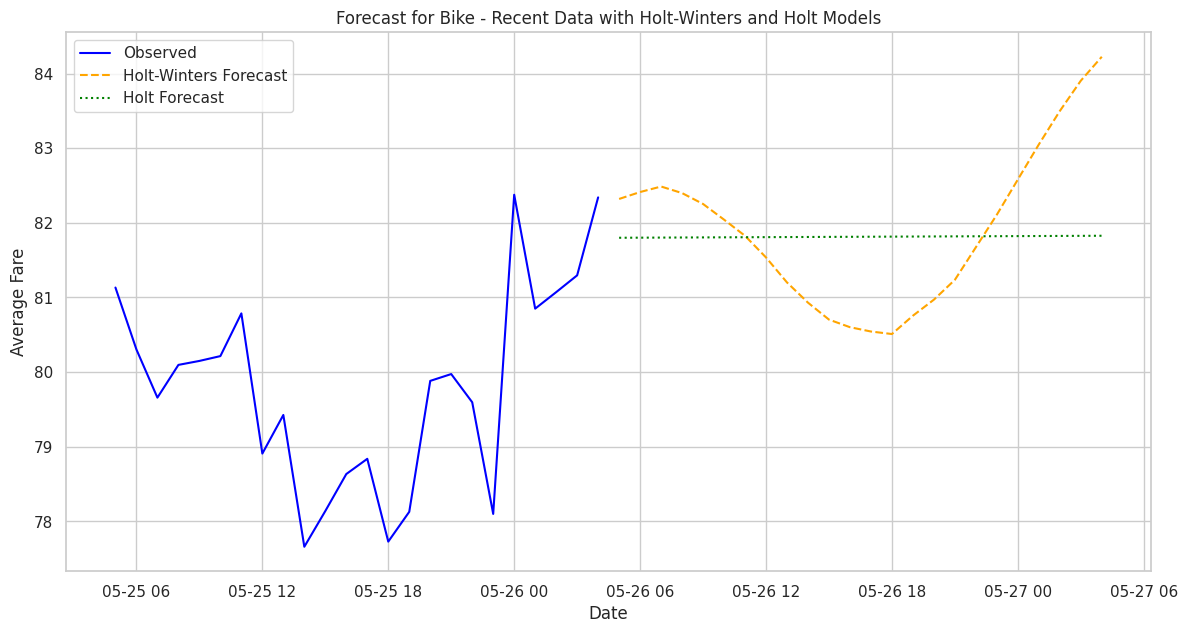


Stationarity Test for Car:
ADF Statistic: -1.8619436504858908
p-value: 0.3501702333000294
Critical Values:
   1%: -3.4306620575014812
   5%: -2.8616779187954124
   10%: -2.5668434103459283
car series is not-stationary

Forecasting for Car using Holt and Holt-Winters models


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_30/2551056400.py:49: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=pivoted_fares.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')


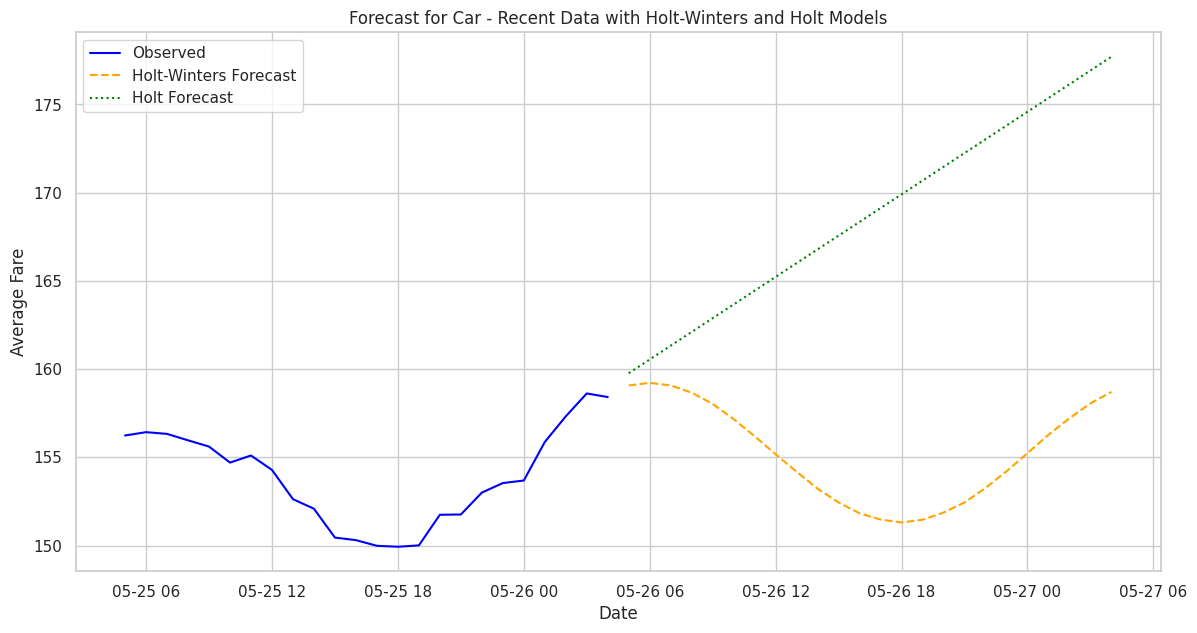

In [28]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

# Load and pivot the data
average_fares = train.groupby(['timestamp', 'vehicle_type'])['average_fare'].mean().reset_index()
pivoted_fares = average_fares.pivot(index='timestamp', columns='vehicle_type', values='average_fare')

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1]

# Loop through each vehicle type
for vehicle in pivoted_fares.columns:
    
    # Call the ADF test function on the time series
    print(f"\nStationarity Test for {vehicle.capitalize()}:")
    pval = adf_test(pivoted_fares[vehicle])
    
    if pval < 0.05:
        print(f"{vehicle} series is stationary")
    else:
        print(f"{vehicle} series is not-stationary")
    
    print(f"\nForecasting for {vehicle.capitalize()} using Holt and Holt-Winters models")

    # Calculate Holt-Winters and Holt forecasts over the full dataset period
    hw_model = ExponentialSmoothing(
        pivoted_fares[vehicle], trend='add', seasonal='add', seasonal_periods=24
    ).fit()

    holt_model = Holt(pivoted_fares[vehicle]).fit()

    # Calculate forecasts for the next 24 periods (e.g., hours)
    forecast_hw = hw_model.forecast(steps=24)
    forecast_holt = holt_model.forecast(steps=24)

    # Create a date range for the forecasted values, starting from the last timestamp
    forecast_index = pd.date_range(start=pivoted_fares.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')

    # Plot the recent observed data and forecasts
    plt.figure(figsize=(14, 7))
    plt.plot(pivoted_fares.index[-24:], pivoted_fares[vehicle].iloc[-24:], label='Observed', color='blue')  # Plot recent observed data
    plt.plot(forecast_index, forecast_hw, label='Holt-Winters Forecast', color='orange', linestyle='--')
    plt.plot(forecast_index, forecast_holt, label='Holt Forecast', color='green', linestyle=':')
    plt.title(f'Forecast for {vehicle.capitalize()} - Recent Data with Holt-Winters and Holt Models')
    plt.xlabel('Date')
    plt.ylabel('Average Fare')
    plt.legend()
    plt.show()


**Holts is used when the time-series has only trend but no seasonality.
Hence we'll use Holts for Auto (as from the ADF-test we know that it is stationary- has no trend or seasonality component.)**           

**Holts-Winter is used when the time-series has to account for both trend and seasonality.           
We'll use Holts-Winter for Bike and Car, as they are not-stationary and have a seasonality component.**

### Task 3: Advanced Forecasting and Feature Engineering (1 mark)

Leveraging insights from Tasks 1 and 2, develop more sophisticated time series models to forecast future average fares for each vehicle type.
- Implement at least one advanced forecasting method (e.g., ARIMA/ARIMAX, SARIMA/SARIMAX, or another technique of your choice).
- Perform feature engineering to incorporate additional relevant variables beyond just the time component to enhance your fare predictions.
- After completing your feature engineering process, list and explain the top 3 most influential features that affect fare predictions, supported by appropriate metrics or visualizations.
- Explain your choice of forecasting method and the rationale behind your feature engineering process.
- Interpret your model results and fare forecasts, relating them to RideWave's operations and the dynamics of fare pricing across different vehicle types.


Vehicle Type: Auto


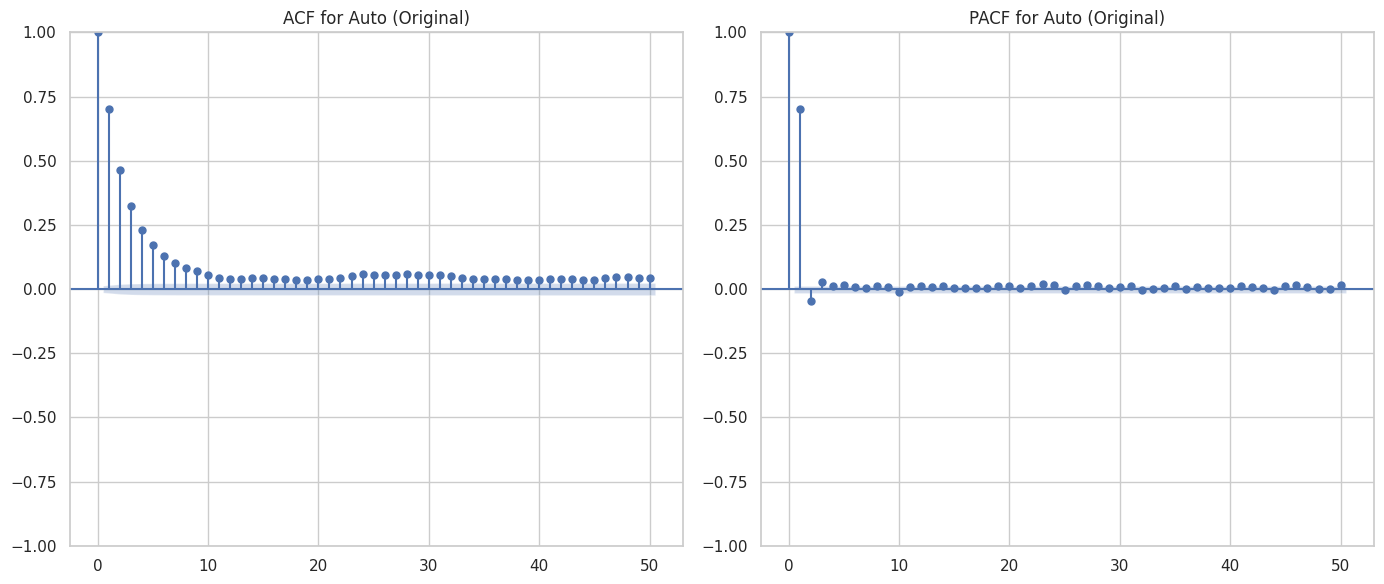

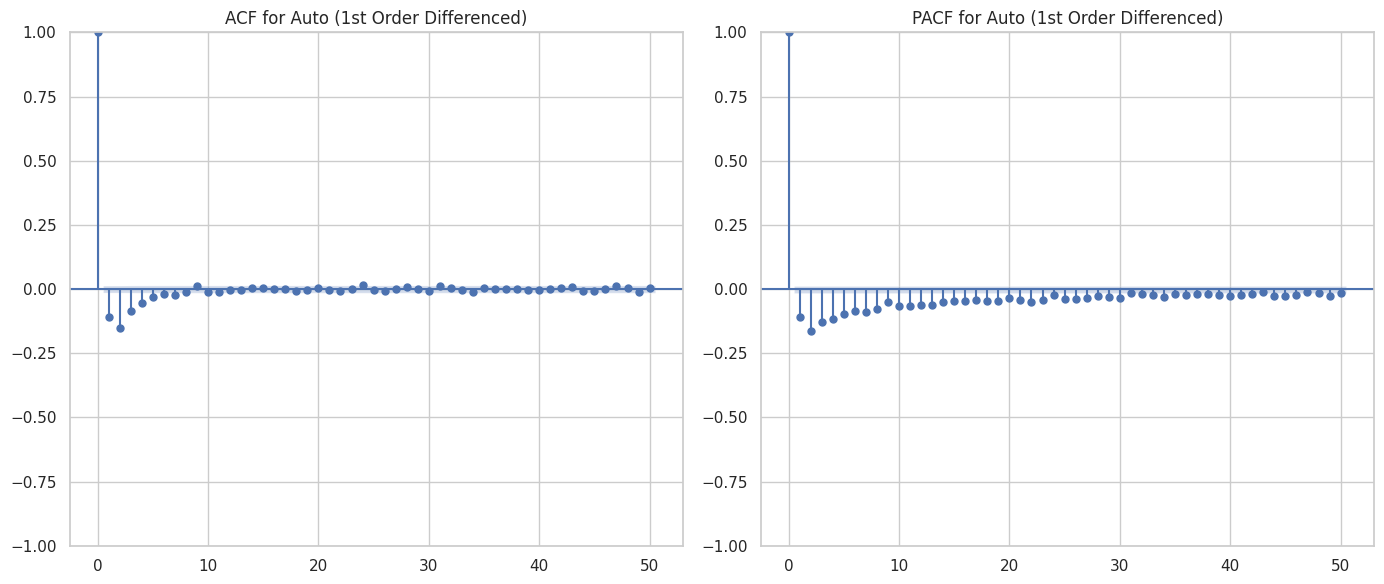


Vehicle Type: Bike


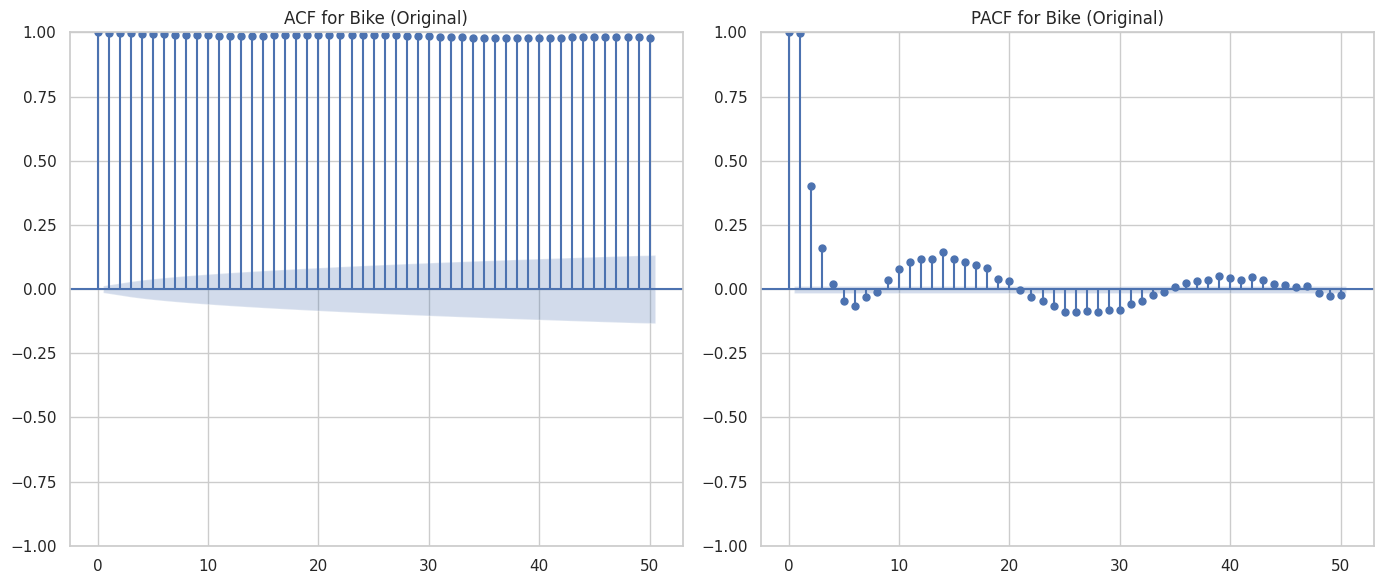

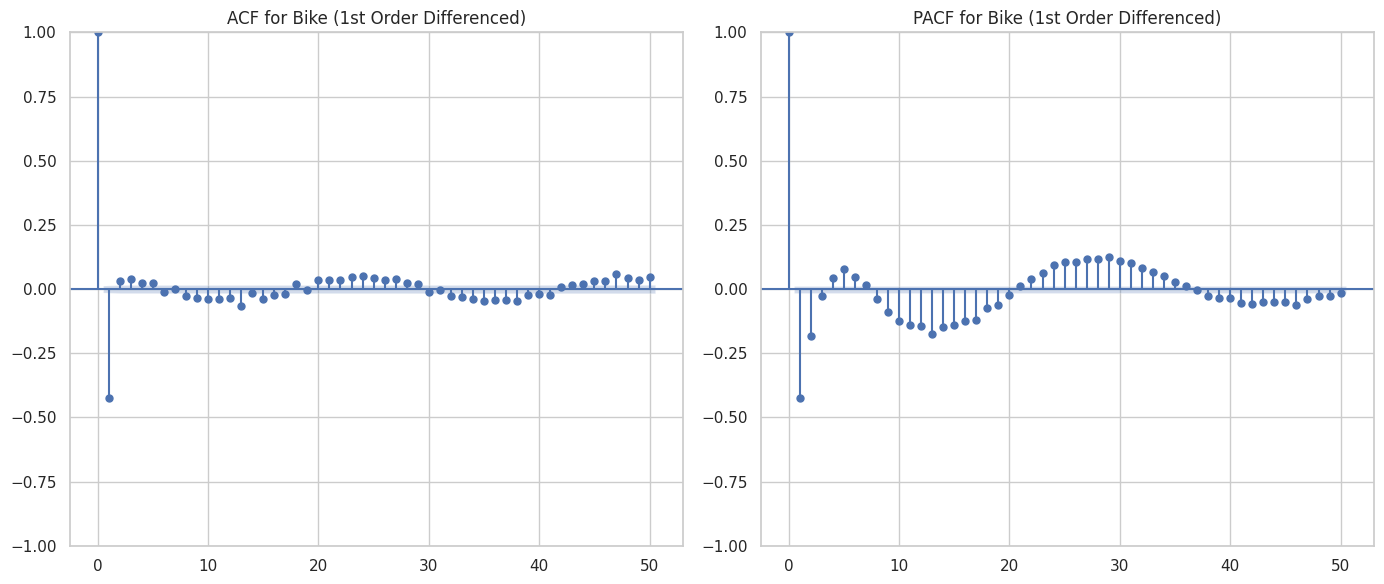


Vehicle Type: Car


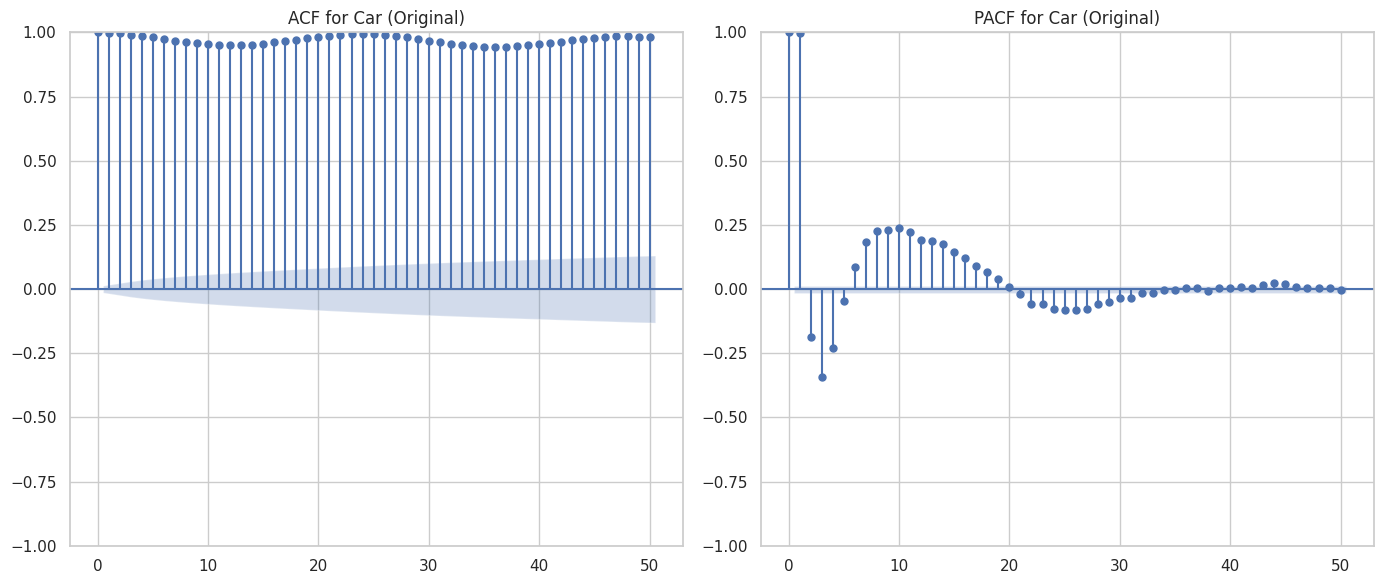

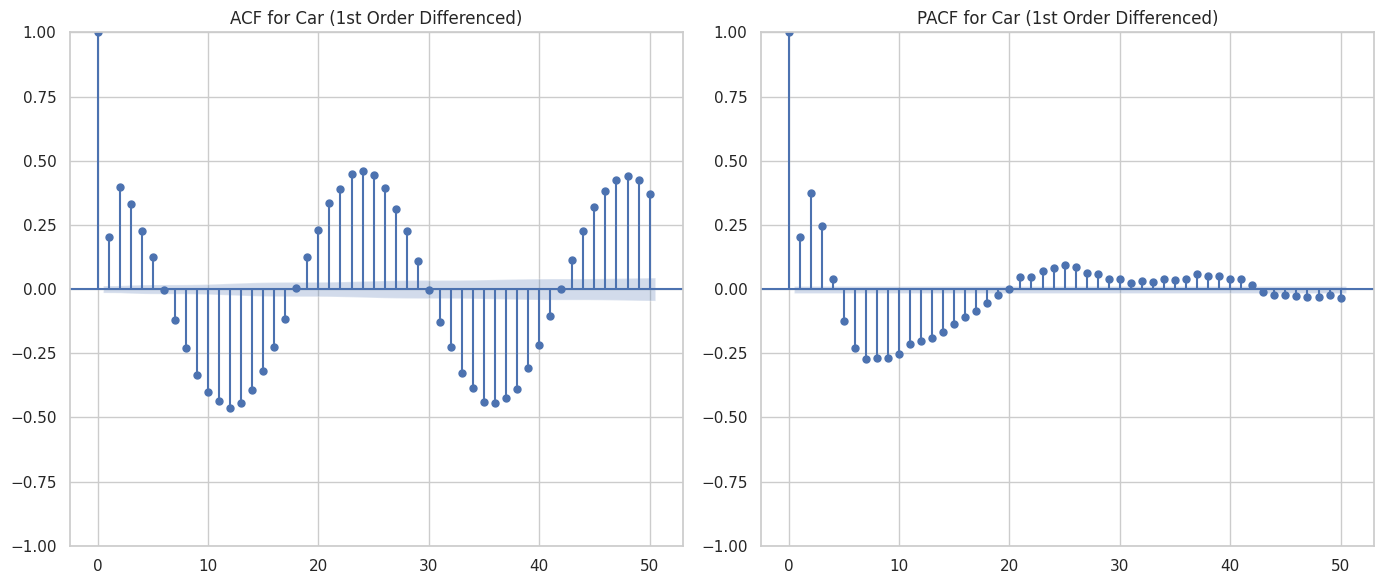

In [29]:
# Loop through each vehicle type
for vehicle in pivoted_fares.columns:
    print(f"\nVehicle Type: {vehicle.capitalize()}")

    # Original series
    series = pivoted_fares[vehicle].dropna()

    # First-order differenced series
    differenced_series_1 = series.diff().dropna()

    # Second-order differenced series
    differenced_series_2 = differenced_series_1.diff().dropna()

    # List of series and titles for loop iteration
    series_list = [
        (series, "Original"),
        (differenced_series_1, "1st Order Differenced")
    ]

    # Loop through each series (original, 1st differenced)
    for diff_series, title in series_list:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # ACF Plot
        plot_acf(diff_series, lags=50, ax=axs[0])
        axs[0].set_title(f'ACF for {vehicle.capitalize()} ({title})')

        # PACF Plot
        plot_pacf(diff_series, lags=50, ax=axs[1])
        axs[1].set_title(f'PACF for {vehicle.capitalize()} ({title})')

        plt.tight_layout()
        plt.show()

**We observe that the acf plots for car, auto and bike decline slowly, showing high correlation with lagged values even over a long range. This suggests that the series is not yet stationary, indicating that it needs to be differentiated, therefore d has to be increased.**

**When d=1 for car. auto and bike, ACF plot shows quick decay and cuts within few lags, suggesting that d=1 is sufficient.**

**We observe that ACF plot for car at d=1 is sinosoidal indicating the presence of cycles or seasonality, and this is where the seasonal differencing(D=1) is necessary.**



**From the above plots ,(p depending on which lag pacf plot cuts at and q depending on which lag acf plot cuts at) 
p=0 ,d=1and q=1 for Auto           
p=2 ,d=1 and q=2 for bike             
p=1 ,d=1and q=1 for car**

**Feature engineering to incorporate additional relevant variables:**

**We start by one-hot encoding the "weather" variable so that it can be incorporated.**

**Based on the correlogram plotted in task-1 we infer that rides_completed and driver_availability are the most correlated with average_fare. Hence these two varibales are important.**

In [30]:
# Load the exogenous data (only weather)
exogenous_weather = train[['timestamp', 'weather']]

# One-hot encode the 'weather' variable
exogenous_weather_encoded = pd.get_dummies(
    exogenous_weather['weather'],
    drop_first=True,
    prefix='weather'
)

# Concatenate the timestamp with the encoded weather variables
exogenous_weather = pd.concat([exogenous_weather[['timestamp']], exogenous_weather_encoded], axis=1)

# Group by timestamp and take the mean of the encoded values
exogenous_weather_grouped = exogenous_weather.groupby('timestamp').mean().reset_index()

# Set the timestamp as the index
exogenous_weather_grouped.set_index('timestamp', inplace=True)

# Group and pivot the data for rides completed and driver availability
exogenous_rides = train.groupby(['timestamp'])[['rides_completed', 'driver_availability']].mean().reset_index()
exogenous_rides.set_index('timestamp', inplace=True)

# Combine the pivoted_fares with both sets of exogenous variables
pivoted_fares = pivoted_fares.join(exogenous_weather_grouped).join(exogenous_rides)

print(pivoted_fares.tail())
pivoted_fares.info()


                          auto       bike         car  weather_Cloudy  \
timestamp                                                               
2023-05-26 00:00:00  42.645070  82.376134  153.686305        0.333333   
2023-05-26 01:00:00  46.028754  80.850678  155.868476        0.000000   
2023-05-26 02:00:00  42.874589  81.071397  157.323043        0.333333   
2023-05-26 03:00:00  41.013707  81.296708  158.620295        0.333333   
2023-05-26 04:00:00  41.573651  82.340854  158.416337        0.333333   

                     weather_Rainy  weather_Stormy  rides_completed  \
timestamp                                                             
2023-05-26 00:00:00       0.000000        0.333333        92.000000   
2023-05-26 01:00:00       0.000000        0.000000       143.000000   
2023-05-26 02:00:00       0.000000        0.000000       109.666667   
2023-05-26 03:00:00       0.333333        0.000000        72.333333   
2023-05-26 04:00:00       0.000000        0.000000       171.6


Fitting SARIMA model for Auto...


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


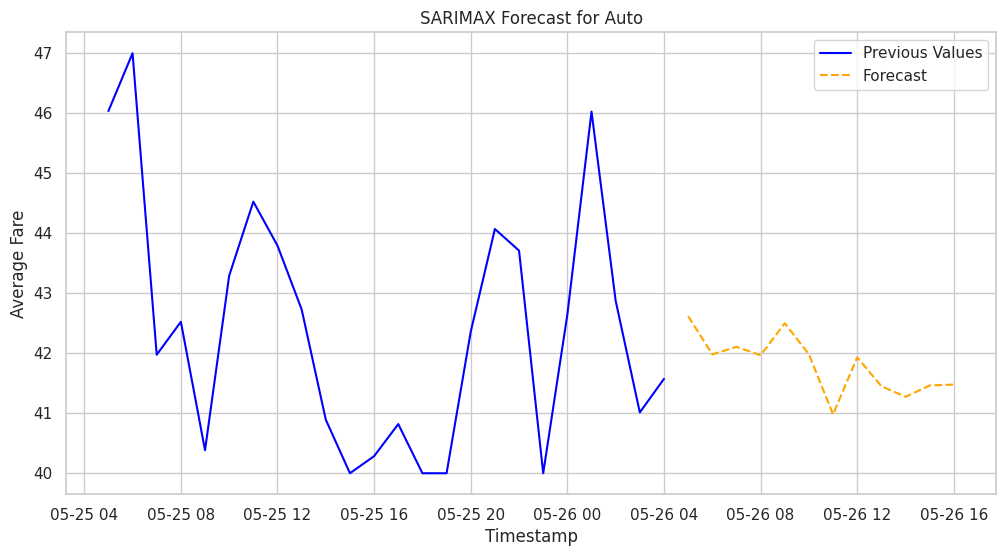


Model Summary for Auto:

                                      SARIMAX Results                                      
Dep. Variable:                                auto   No. Observations:                21005
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 24)   Log Likelihood              -36362.756
Date:                             Sat, 02 Nov 2024   AIC                          72741.512
Time:                                     05:53:41   BIC                          72805.132
Sample:                                 01-01-2021   HQIC                         72762.277
                                      - 05-26-2023                                         
Covariance Type:                               opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
weather_Cloudy          0.0849      0.033      2.592      0.01

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


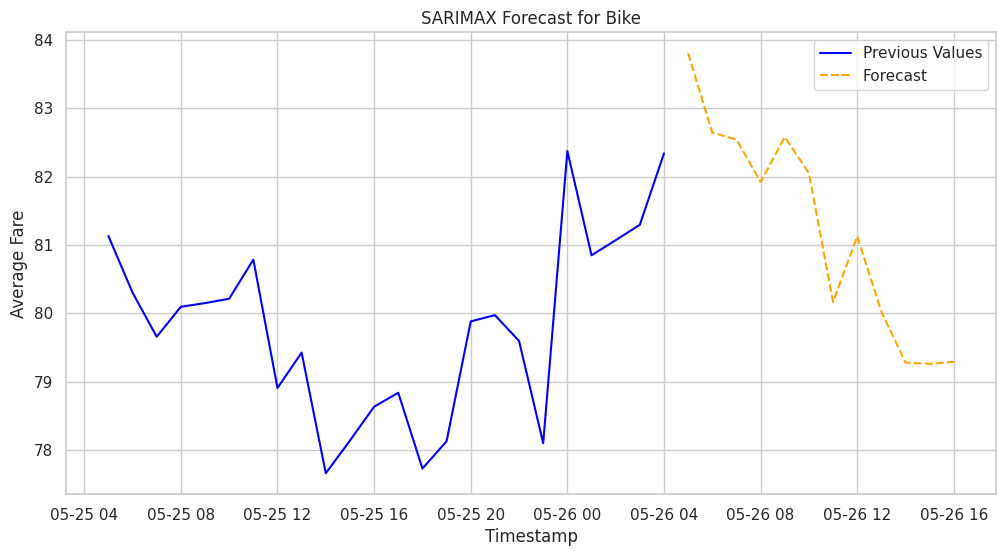


Model Summary for Bike:

                                      SARIMAX Results                                       
Dep. Variable:                                 bike   No. Observations:                21005
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -21443.471
Date:                              Sat, 02 Nov 2024   AIC                          42908.942
Time:                                      06:07:14   BIC                          42996.407
Sample:                                  01-01-2021   HQIC                         42937.492
                                       - 05-26-2023                                         
Covariance Type:                                opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
weather_Cloudy          0.2095      0.018     11.867  

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


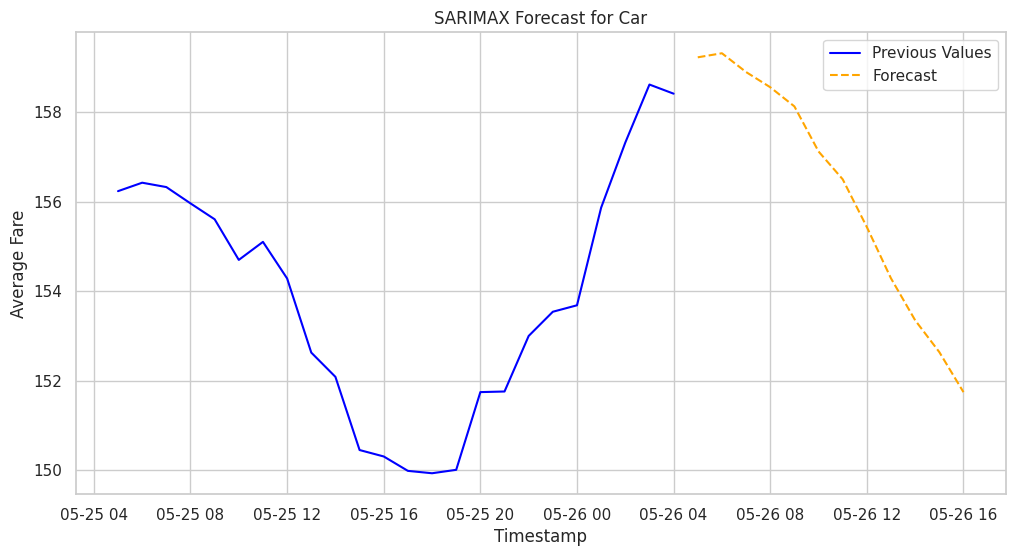


Model Summary for Car:

                                     SARIMAX Results                                      
Dep. Variable:                                car   No. Observations:                21005
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -23897.201
Date:                            Sat, 02 Nov 2024   AIC                          47812.402
Time:                                    06:19:15   BIC                          47883.964
Sample:                                01-01-2021   HQIC                         47835.761
                                     - 05-26-2023                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
weather_Cloudy          0.0142      0.019      0.746      0.455      -0

In [32]:
# Specify seasonal parameters
seasonal_order_auto = (1, 0, 0, 24)  # Adjust P, D, Q as needed for Auto
seasonal_order_bike = (0, 1, 1, 24)  # Adjust P, D, Q as needed for Bike
seasonal_order_car = (0, 1, 1, 24)   # Adjust P, D, Q as needed for Car

# Prepare exogenous variables
exogenous_vars = pivoted_fares[['weather_Cloudy', 'weather_Rainy', 'weather_Stormy', 'rides_completed', 'driver_availability']]

# Fit SARIMA models for each vehicle
models = {}
forecasts = {}

# Vehicle-specific configurations
vehicle_configs = {
    'auto': {'p': 0, 'd': 1, 'q': 1, 'seasonal_order': seasonal_order_auto},
    'bike': {'p': 2, 'd': 1, 'q': 2, 'seasonal_order': seasonal_order_bike},
    'car':  {'p': 1, 'd': 1, 'q': 1, 'seasonal_order': seasonal_order_car},
}

for vehicle, config in vehicle_configs.items():
    print(f"\nFitting SARIMA model for {vehicle.capitalize()}...")
    
    # Prepare target variable and align exogenous variables
    target = pivoted_fares[vehicle].dropna()
    exog = exogenous_vars.loc[target.index]  # Align exogenous variables with the target
    
    # Fit the SARIMA model
    model = SARIMAX(
        target,
        order=(config['p'], config['d'], config['q']),
        seasonal_order=config['seasonal_order'],
        exog=exog  # Include exogenous variables
    ).fit(disp=False)
    
    models[vehicle] = model
    
    # Generate forecasts
    forecast = model.get_forecast(steps=12, exog=exogenous_vars.tail(12)).predicted_mean  # Use the last 12 rows for forecasting
    forecasts[vehicle] = forecast
    
    # Determine the number of previous values to plot
    n_previous = 24  # Number of previous values to show
    previous_values = target.tail(n_previous)  # Get the last n_previous values
    
    # Plot the forecast with previous values
    plt.figure(figsize=(12, 6))
    plt.plot(previous_values.index, previous_values, label='Previous Values', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')
    plt.title(f'SARIMAX Forecast for {vehicle.capitalize()}')
    plt.xlabel('Timestamp')
    plt.ylabel('Average Fare')
    plt.legend()
    plt.show()
    
    # Print model summary
    print(f"\nModel Summary for {vehicle.capitalize()}:\n")
    print(model.summary())


**Auto:**

Weather Effects:

Cloudy: Coefficient = 0.2095; highly significant (p < 0.001). Moderate increase in bike usage on cloudy days.
Rainy: Coefficient = 0.7629; highly significant (p < 0.001). Significant increase in usage on rainy days.
Stormy: Coefficient = 1.0992; highly significant (p < 0.001). Largest increase in usage, indicating strong demand during storms.
Rides Completed:

Coefficient = -0.0021; highly significant (p < 0.001). Indicates a slight decrease in bike usage as rides completed increase, possibly due to demand saturation.
Driver Availability:

Coefficient = 0.0972; highly significant (p < 0.001). Positive effect on bike usage, suggesting higher driver availability boosts demand.
AR and MA Terms:

AR.L1: Coefficient = -0.7558; highly significant (p < 0.001). Indicates influence of immediate past values on current demand.
AR.L2: Coefficient = -0.2296; highly significant (p < 0.001). Shows a secondary short-term autoregressive effect.
MA.L1: Coefficient = 0.0096; not significant (p = 0.809), meaning it has no substantial effect.
MA.L2: Coefficient = -0.2530; highly significant (p < 0.001), indicating short-term error correction.
Seasonal MA (L24): Coefficient = -0.8892; highly significant (p < 0.001). Strong seasonal moving average effect at a lag of 24 periods.
Residual Variance (sigma²):

Coefficient = 0.4315; highly significant (p < 0.001), representing the model’s error variance.
Inference Summary
Weather conditions, rides completed, driver availability, AR(1), AR(2), MA(2), and seasonal MA(1) are significant factors influencing bike usage.

**Bike:**

Weather Effects:
Cloudy: Coefficient = 0.2095; highly significant (p < 0.001). Moderate increase in bike usage on cloudy days.
Rainy: Coefficient = 0.7629; highly significant (p < 0.001). Significant increase in usage on rainy days.
Stormy: Coefficient = 1.0992; highly significant (p < 0.001). Largest increase in usage, indicating strong demand during storms.
Rides Completed:

Coefficient = -0.0021; highly significant (p < 0.001). Indicates a slight decrease in bike usage as rides completed increase, possibly due to demand saturation.
Driver Availability:

Coefficient = 0.0972; highly significant (p < 0.001). Positive effect on bike usage, suggesting higher driver availability boosts demand.
AR and MA Terms:

AR.L1: Coefficient = -0.7558; highly significant (p < 0.001). Indicates influence of immediate past values on current demand.
AR.L2: Coefficient = -0.2296; highly significant (p < 0.001). Shows a secondary short-term autoregressive effect.
MA.L1: Coefficient = 0.0096; not significant (p = 0.809), meaning it has no substantial effect.
MA.L2: Coefficient = -0.2530; highly significant (p < 0.001), indicating short-term error correction.
Seasonal MA (L24): Coefficient = -0.8892; highly significant (p < 0.001). Strong seasonal moving average effect at a lag of 24 periods.
Residual Variance (sigma²):

Coefficient = 0.4315; highly significant (p < 0.001), representing the model’s error variance.
Inference Summary
Weather conditions, rides completed, driver availability, AR(1), AR(2), MA(2), and seasonal MA(1) are significant factors influencing bike usage.

**Car:**

Weather Effects:

Cloudy: Coefficient = 0.0142; not significant (p = 0.455). No notable effect on car usage on cloudy days.
Rainy: Coefficient = 0.0616; statistically significant (p = 0.007). Small increase in car usage on rainy days.
Stormy: Coefficient = 0.0114; not significant (p = 0.760). No meaningful effect on usage during storms.
Rides Completed:

Coefficient = -0.0002; statistically significant (p = 0.001). Slight decrease in car usage as rides completed increase, potentially due to demand saturation.
Driver Availability:

Coefficient = 0.0021; statistically significant (p = 0.001). Small positive effect, indicating higher availability of drivers slightly increases car usage.
AR and MA Terms:

AR.L1: Coefficient = -0.2917; highly significant (p < 0.001). Reflects influence of recent past values on current demand.
MA.L1: Coefficient = -0.1853; highly significant (p < 0.001). Short-term error correction effect.
Seasonal MA (L24): Coefficient = -0.9309; highly significant (p < 0.001). Strong seasonal dependency at a lag of 24 periods, showing strong influence from previous seasonal patterns.
Residual Variance (sigma²):

Coefficient = 0.5674; highly significant (p < 0.001), indicating the model’s error variance.
Inference Summary
The Rainy weather, rides completed, driver availability, AR(1), MA(1), and seasonal MA(1) terms are significant factors in explaining car usage patterns.








### Task 4: Ensemble Modeling and Pricing Strategy (1 mark)

- Based on your work from previous tasks, analyze the relationships between fares of different vehicle types in Quahog City.
- Develop 3 different sophisticated forecasting models **(one for each vehicle type)**, with appropriate feature engineering for each vehicle type.

You must use the following 3 models for your forecasting:

1. ARIMA / ARIMAX / SARIMA / SARIMAX
2. Any method of your choice
3.  Any method of your choice that is NOT in the following list: Holt Winter's, ARIMA, ARIMAX, SARIMA, SARIMAX
   


Here are some models you can consider:
1) ARCH (https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity)
2) GARCH (https://www.investopedia.com/terms/g/garch.asp)
3) VAR (https://en.wikipedia.org/wiki/Vector_autoregression#:~:text=VAR%20is%20a%20type%20of,economics%20and%20the%20natural%20sciences.)
4) XGBoost (https://en.wikipedia.org/wiki/XGBoost)

Explain the rationale behind your choice of model for the corresponding vehicle type.

RideWave are looking to create a unified model incorporating all 3 of the models you have developed.
- How would you go about implementing an ensemble modelling approach using all 3 models? 
##### (You don't have to write code for this, but the explanation must be detailed)





# 1) Model for Auto(SARIMAX)

**This SARIMAX model is a well-suited approach for forecasting the average fare for auto rides, taking into account both seasonal effects and external influencing factors (weather, ride completions, etc.). By incorporating exogenous variables, the model can account for non-seasonal shifts in the time series, providing more accurate forecasts than a simple ARIMA model would.**


Fitting SARIMAX model for Auto...


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


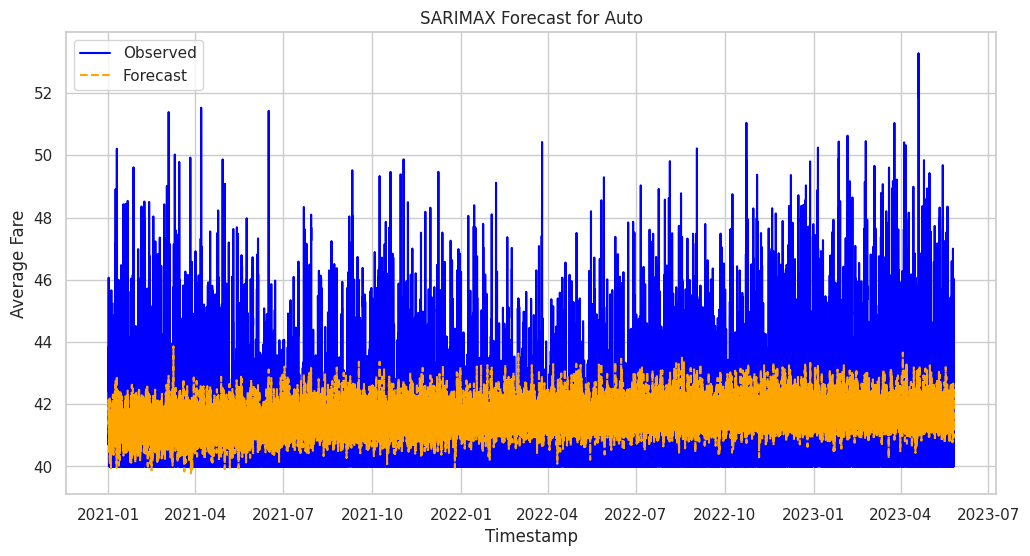

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Specify seasonal parameters for Auto
seasonal_order_auto = (1, 0, 0, 24)  # Adjust P, D, Q as needed

# Fit the SARIMAX model for Auto
print("\nFitting SARIMAX model for Auto...")

# Prepare the target variable
auto_target = pivoted_fares['auto'].dropna()  # Ensure there are no NaN values

# Prepare exogenous variables
exogenous_vars = pivoted_fares[['weather_Cloudy', 'weather_Rainy','weather_Stormy','rides_completed', 'driver_availability']].loc[auto_target.index]

# Fit the SARIMAX model using the entire dataset
model_auto = SARIMAX(
    auto_target,
    order=(0, 1, 1),  # Adjust as needed
    seasonal_order=seasonal_order_auto,
    exog=exogenous_vars  # Include exogenous variables
).fit(disp=False)

# Generate forecasts for the entire dataset
forecast_auto = model_auto.get_forecast(steps=len(auto_target), exog=exogenous_vars).predicted_mean

# Plot the forecast against the observed data
plt.figure(figsize=(12, 6))
plt.plot(auto_target.index, auto_target, label='Observed', color='blue')
plt.plot(auto_target.index, forecast_auto, label='Forecast', color='orange', linestyle='--')
plt.title('SARIMAX Forecast for Auto')
plt.xlabel('Timestamp')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

# No predictions DataFrame created

# Model for Car(Custom model using fast-fourier-transform)

**This regression model posits that the observed data can be represented as the sum of a linear term (time index t) and Fourier series terms. The linear term accounts for underlying trends, while the Fourier series terms capture periodic fluctuations within the data.**

**The model operates by identifying critical frequencies from the differenced data and subsequently fitting these frequencies alongside the linear term to the original time series.**

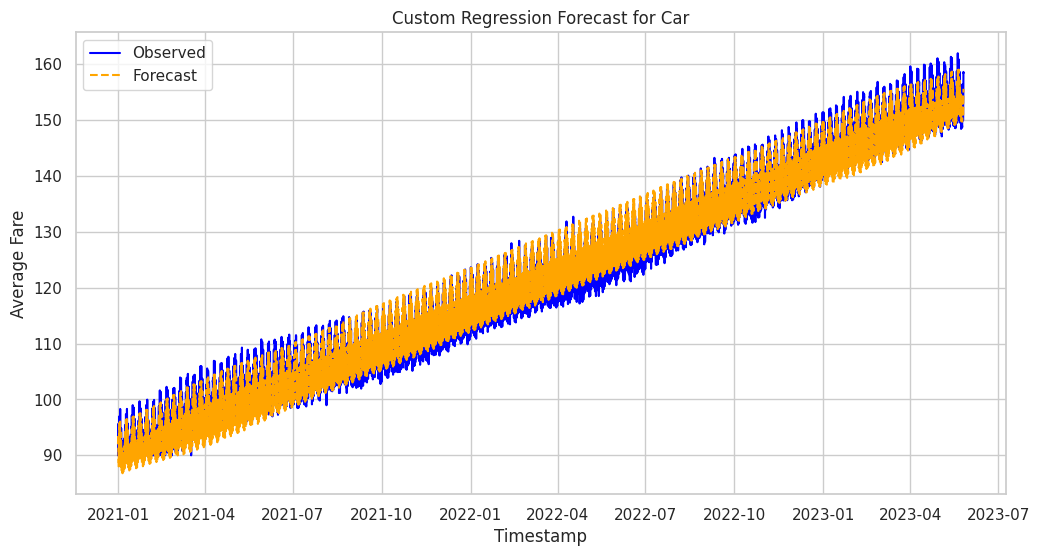

Model Summary:
R-squared: 0.9954
Mean Absolute Error (MAE): 1.0614
Mean Squared Error (MSE): 1.6156
Root Mean Squared Error (RMSE): 1.2710
0


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `pivoted_fares` DataFrame is already defined with 'car' column

# Prepare target variable and time index
car_target = pivoted_fares['car'].dropna()
time_index = np.arange(len(car_target))

# Difference the time series
car_diff = car_target.diff().dropna()

# Apply FFT
fft_result = np.fft.fft(car_diff)
fft_freq = np.fft.fftfreq(len(car_diff))

# Get magnitude of the FFT components
fft_magnitude = np.abs(fft_result)

# Identify significant frequencies (e.g., top 5)
num_significant = 75
indices = np.argsort(fft_magnitude)[-num_significant:]  # Indices of largest magnitudes
significant_frequencies = fft_freq[indices]
significant_coefficients = fft_result[indices]

# Function to create Fourier features for the significant frequencies
def fourier_features(t, significant_frequencies):
    features = []
    for freq in significant_frequencies:
        features.append(np.sin(2 * np.pi * freq * t))
        features.append(np.cos(2 * np.pi * freq * t))
    return np.column_stack(features)

# Create Fourier features for the significant frequencies
fourier_features_matrix = fourier_features(time_index, significant_frequencies)

# Create design matrix including the linear term
X_car = np.column_stack((time_index, fourier_features_matrix))

# Train custom regression model on the entire dataset
car_model = LinearRegression()
car_model.fit(X_car, car_target)

# Make predictions for the entire dataset
car_forecast_full = car_model.predict(X_car)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(car_target.index, car_target, label='Observed', color='blue')
plt.plot(car_target.index, car_forecast_full, label='Forecast', color='orange', linestyle='--')
plt.title('Custom Regression Forecast for Car')
plt.xlabel('Timestamp')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

# Model summary
r_squared = car_model.score(X_car, car_target)
mae = mean_absolute_error(car_target, car_forecast_full)
mse = mean_squared_error(car_target, car_forecast_full)
rmse = np.sqrt(mse)

print(f"Model Summary:")
print(f"R-squared: {r_squared:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

print((time_index[0]))

# Model for Bike(XGBoost)

**XGBoost (Extreme Gradient Boosting)  technique  builds an ensemble of decision trees in a sequential manner. Since it is based on decision trees, it can model non linear relationships ,trend and seasonality effectively.Which proves to be a good fit for predicting bike fare since the data has both seasonality and trend**

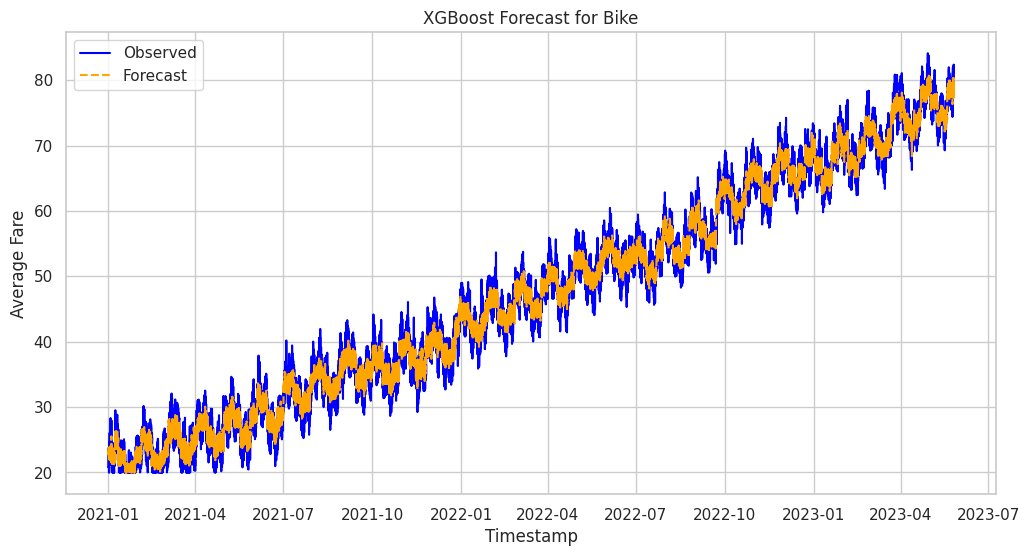

XGBoost Model Performance for Bike:
Mean Absolute Error (MAE): 1.3406
Mean Squared Error (MSE): 2.7820
Root Mean Squared Error (RMSE): 1.6679
R-squared: 0.9902
Max Predicted Fare: 80.687775


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming `pivoted_fares` DataFrame is already defined with 'bike', 'rides_completed', and 'driver_availability' columns

# Prepare the target variable
bike_target = pivoted_fares['bike'].dropna()  # Ensure there are no NaN values

# Prepare exogenous variables
exogenous_vars = pivoted_fares[['weather_Cloudy', 'weather_Rainy','weather_Stormy','rides_completed', 'driver_availability']].loc[bike_target.index]  # Align with bike_target

# Define time index for features
time_index = np.arange(len(bike_target))

# Create design matrix including the time index and exogenous variables
X_bike = np.column_stack((time_index, exogenous_vars))

# Train XGBoost model on the entire dataset
bike_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01)
bike_model.fit(X_bike, bike_target)

# Make predictions for the entire dataset
bike_forecast_full = bike_model.predict(X_bike)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(pivoted_fares.index, bike_target, label='Observed', color='blue')
plt.plot(pivoted_fares.index, bike_forecast_full, label='Forecast', color='orange', linestyle='--')
plt.title('XGBoost Forecast for Bike')
plt.xlabel('Timestamp')
plt.ylabel('Average Fare')
plt.legend()
plt.show()

# Print model performance metrics
mae = mean_absolute_error(bike_target, bike_forecast_full)
mse = mean_squared_error(bike_target, bike_forecast_full)
rmse = np.sqrt(mse)
r_squared = r2_score(bike_target, bike_forecast_full)

print(f'XGBoost Model Performance for Bike:')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared: {r_squared:.4f}')
print("Max Predicted Fare:", max(bike_forecast_full))

**Ensemble:**


**Averaging or Weighted Averaging: A simple ensemble method is to average the predictions from each model or assign weights based on each model’s performance on validation data.**



**Stacking:Train “meta-model” (like a linear regression) on the predictions from each base model to learn optimal ways of combining them. For example, in Skforecast, the ForecasterAutoreg class allows flexible stacking by feeding previous predictions into a higher-level model.**



**Bayesian Model Averaging: Consider advanced techniques like Bayesian model averaging to assign probabilistic weights based on the performance of each model across different conditions.**



## Example submission, just for your reference

In [37]:
submission = pd.DataFrame()
sample_submission = pd.read_csv('/kaggle/input/data-analytics-ue-22-cs-342-aa-2-hackathon-2/sample_submission.csv')


In [38]:

# Ensure timestamps are in datetime format
test['timestamp'] = pd.to_datetime(test['timestamp'])  # Also ensure test timestamps are datetime

# Load the exogenous weather data
exogenous_weather_test = test[['timestamp', 'weather']]

# One-hot encode the 'weather' variable
exogenous_weather_encoded_test = pd.get_dummies(
    exogenous_weather_test['weather'],
    drop_first=True,
    prefix='weather'
)

# Concatenate the timestamp with the encoded weather variables
exogenous_weather_test = pd.concat([exogenous_weather_test[['timestamp']], exogenous_weather_encoded_test], axis=1)

# Group by timestamp and take the mean of the encoded values
exogenous_weather_grouped_test = exogenous_weather_test.groupby('timestamp').mean().reset_index()
exogenous_weather_grouped_test.set_index('timestamp', inplace=True)

# Group and pivot the data for rides completed and driver availability
exogenous_rides_test = test.groupby(['timestamp'])[['rides_completed', 'driver_availability']].mean().reset_index()
exogenous_rides_test.set_index('timestamp', inplace=True)

# Combine the exogenous weather and rides completed data
pivoted_fares_test = exogenous_weather_grouped_test.join(exogenous_rides_test)

# Display the combined test DataFrame
print(pivoted_fares_test.tail())
pivoted_fares_test.info()


                     weather_Cloudy  weather_Rainy  weather_Stormy  \
timestamp                                                            
2023-12-30 20:00:00        0.000000            0.0        0.333333   
2023-12-30 21:00:00        0.333333            0.0        0.000000   
2023-12-30 22:00:00        0.333333            0.0        0.000000   
2023-12-30 23:00:00        0.000000            0.0        0.000000   
2023-12-31 00:00:00        0.000000            0.0        0.666667   

                     rides_completed  driver_availability  
timestamp                                                  
2023-12-30 20:00:00       192.666667            40.027599  
2023-12-30 21:00:00       236.666667            56.924737  
2023-12-30 22:00:00       284.333333            42.354599  
2023-12-30 23:00:00       322.666667            48.261931  
2023-12-31 00:00:00        77.333333            30.000000  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5252 entries, 2023-05-26 05:00:00 to

## We have used a sample-submission just to show you the format your submission should be in, you have to use your OWN forecasts while making submissions


In [39]:
"""submission['timestamp'] = sample_submission['timestamp']
submission['average_fare_bike'] = sample_submission['average_fare_bike']
submission['average_fare_auto'] = sample_submission['average_fare_auto']
submission['average_fare_car'] = sample_submission['average_fare_car']"""

# Determine the length of the training set
N_train = len(pivoted_fares)
# Create a new time index for the test dataset
test_time_index = np.arange(N_train, N_train + len(pivoted_fares_test))
# Create Fourier features for the test dataset using the new time index
fourier_features_matrix_test = fourier_features(test_time_index, significant_frequencies)
# Create design matrix for the test dataset
X_car_test = np.column_stack((test_time_index, fourier_features_matrix_test))
# Make predictions using the trained model
car_predictions = car_model.predict(X_car_test)
# Create the submission DataFrame
submission = pd.DataFrame()
submission['timestamp'] = pivoted_fares_test.index  # Ensure your test DataFrame has an index of timestamps
submission['average_fare_car'] = car_predictions
# Display the submission DataFrame
print(submission.head())


# Prepare exogenous variables for the test dataset for the bike model
exogenous_vars_test = pivoted_fares_test[['weather_Cloudy', 'weather_Rainy', 'weather_Stormy', 
                                           'rides_completed', 'driver_availability']]
# Create a new time index for the test dataset for the bike model, similar to the car model
test_time_index_bike = np.arange(N_train, N_train + len(exogenous_vars_test))
# Create design matrix for the test dataset for the bike model
X_bike_test = np.column_stack((test_time_index_bike, exogenous_vars_test))
# Make predictions using the trained bike model
bike_predictions = bike_model.predict(X_bike_test)
# Add bike predictions to the existing submission DataFrame
submission['average_fare_bike'] = bike_predictions
# Display the updated submission DataFrame for both models
print(submission.head())


# Prepare exogenous variables for the test dataset
exogenous_vars_test = pivoted_fares_test[['weather_Cloudy', 'weather_Rainy', 'weather_Stormy', 
                                           'rides_completed', 'driver_availability']]
# Generate forecasts using the trained SARIMAX model
forecast_auto_test = model_auto.get_forecast(steps=len(pivoted_fares_test), exog=exogenous_vars_test).predicted_mean
# Create the submission DataFrame
submission['average_fare_auto'] = forecast_auto_test.values  # Unpack the forecast values
# Display the submission DataFrame
print(submission.head())
print("Max Predicted Fare for Test (Auto):", max(submission['average_fare_auto']))





            timestamp  average_fare_car
0 2023-05-26 05:00:00        156.367042
1 2023-05-26 06:00:00        156.772400
2 2023-05-26 07:00:00        157.106925
3 2023-05-26 08:00:00        157.228023
4 2023-05-26 09:00:00        157.113516
            timestamp  average_fare_car  average_fare_bike
0 2023-05-26 05:00:00        156.367042          78.384117
1 2023-05-26 06:00:00        156.772400          78.123886
2 2023-05-26 07:00:00        157.106925          78.285301
3 2023-05-26 08:00:00        157.228023          78.865250
4 2023-05-26 09:00:00        157.113516          78.213997
            timestamp  average_fare_car  average_fare_bike  average_fare_auto
0 2023-05-26 05:00:00        156.367042          78.384117          42.118528
1 2023-05-26 06:00:00        156.772400          78.123886          41.867711
2 2023-05-26 07:00:00        157.106925          78.285301          41.747388
3 2023-05-26 08:00:00        157.228023          78.865250          42.226834
4 2023-05-26 09:

In [40]:
print(min(submission['timestamp']))
print(min(sample_submission['timestamp']))

2023-05-26 05:00:00
2023-05-26 05:00:00


In [41]:
submission.to_csv('submission.csv', index = False)

## Congratulations! 🎉

You've done it! You've successfully completed the Data Analytics (UE22CS342AA2) Hackathon-2, and that's something to be truly proud of! This achievement shows just how much you've grown in your ability to tackle time-series modeling and analysis.

### Here’s what you’ve accomplished:
- You applied data analytics concepts to solve real-world problems.
- You developed time-series models, a skill that’s essential in fields like finance (think stock predictions) and healthcare (monitoring vitals)—and many more!

### What's next:
With this experience, you’ve laid a solid foundation for real-world data modeling and time-series analysis. The techniques you’ve mastered here will be incredibly valuable in many data science and machine learning projects, no matter the industry.

But remember, this is just the start of your journey in data science! Keep learning, keep pushing yourself, and most importantly, keep having fun with it. You're ready for even more exciting and challenging projects.

**Huge congrats once again, and wishing you all the best for your ISAs and ESAs! You've got this! 🌟** 